In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [77]:
input_path = '/Volumes/Behaviour/S1 2P Recordings for Suite2P'
output_path = '/Volumes/Behaviour/S1 2P Neural Tuning/95th Percentile'
mice = ['2P07','2P08', '2P09', '2P10', '2P11']

In [14]:
directories = [x[0] for x in os.walk(input_path) if os.path.basename(x[0]) == 'plane0']
thresholds95 = pd.DataFrame()

for directory in directories:
    print('Processing:', directory)
    stop = False
    meta = directory.split('/')  #directory.split('\\') 
    session_name = meta[4] #meta[3] 
    print(session_name)
    
    # load Suite2P outputs
    F = np.load(os.path.join(directory, 'F.npy'))
    Fneu = np.load(os.path.join(directory, 'Fneu.npy'))
    iscell = np.load(os.path.join(directory,'iscell.npy'), allow_pickle=True)
                             
    # read trial timings
    sf_path = meta[0]+'/'+meta[1]+'/'+meta[2]+'/'+meta[3] +'/'+ meta[4]
    sf_qc = pd.read_csv(os.path.join(sf_path, '2P_SF_QC.csv'))
    stimframes = np.array(sf_qc['2p_realstim_frame'])
    idx = list(sf_qc['identifier'])
    
    # Subtract neuropil signal from raw traces
    Fc = F - 0.7 * Fneu
    print('matrix shape: ', F.shape)
    
    # Get list of ROIS that are not cells
    iscell = pd.DataFrame(iscell)
    iscell_idx = iscell[0] == 1
    
    # Remove non-cell ROIs from raw traces & raw traces without neuropil
    df_F = pd.DataFrame(F)
    F_isCell = df_F.loc[iscell_idx]
    
    df_Fc = pd.DataFrame(Fc)
    Fc_isCell = df_Fc.loc[iscell_idx]
                             
    # remove ROIs with zero values from raw traces and get new list of indecis corresponding to active ROIs
    F_nonZero = F_isCell.loc[~(F_isCell==0).all(axis=1)]
    activeROIs = list(F_nonZero.index.values)
    print('number of active rois: ', len(activeROIs))

    # keep only active ROIs in F-neuropil
    Fc_Act = df_Fc.loc[df_Fc.index[activeROIs]]
    print('active rois matrix shape: ', Fc_Act.shape)
                             
    if stimframes[0]-183 <0: # determine appropriate length of pre-stimulus baseline based on the number 
        TBL_len = int(stimframes[0]-1) # of frames available before the very first stimulation
    else:
        TBL_len = 183 # default baseline is 30 s (30 * 6.1 fps = 183)
        
# for each active ROI, calculate 5th percentile, then cut out 30 sec pre-, and 60 sec post-stimulation 
# traces and use these to calculate F0 (I call it T0 since it is trial based) as the mean of Q5 in the trial window.
# Then, compute trial-wise dF_F0 (I called them dT_T0) an crop those to a 3 second window centered sround stimulation.
    neural_tuning = pd.DataFrame()
    tuned_maxis = pd.DataFrame()
    thresholds = []
    
    # Generate random distribution of 1999 time points within the recording session and use those to create random 
    # trial windows, then take baseline-subtracted maximum for each of them. Response thresholds = 95th percentile 
    # of the random distribution.
    rand_s = random.sample(range(TBL_len, Fc_Act.shape[1]-366), 1999)
    for r, roi in enumerate(activeROIs):
        Fc_Q05 = Fc_Act.iloc[r,:].rolling(366, center = True).quantile(0.05) # 5th percentile of neuropil-corrected F trace
        
        rand_dist = []
        for rs in rand_s:
            start = int(rs) - int(TBL_len)
            end = int(rs) + 366 # 60 sec * 6.1 fps
            T = Fc_Act.iloc[r,start:end] # trial window of neuropil-corrected F trace
            T_Q05 = Fc_Q05.iloc[start:end] # trial window of 5th percentile trace
            T0 = T_Q05.mean()
            dT_T0_long = (T - T0)/T0
            baseline = dT_T0_long.loc[(int(rs)-3):(int(rs)-1)].mean()
            maxi = dT_T0_long.loc[int(rs):(int(rs)+3)].max()
            response = maxi-baseline
            rand_dist.append(response)
                           
        per95 = np.percentile(rand_dist, 95)
        thresholds.append(per95)
    
    thresholds95.loc[:,session_name] = pd.Series(thresholds)
   
        # Use 95 percentile threshold to identify "tuned neurons" in 655.7 ms post-stimulus time-window ('short')
        tuning = []
        maxis = []
        for s in stimframes:
            start = int(s) - int(TBL_len)
            end = int(s) + 366 # 60 sec * 6.1 fps
            T = Fc_Act.iloc[r,start:end] # trial window of neuropil-corrected F trace
            T_Q05 = Fc_Q05.iloc[start:end] # trial window of 5th percentile trace
            T0 = T_Q05.mean()
            dT_T0_long = (T - T0)/T0
            baseline = dT_T0_long.loc[(int(s)-3):int(s)-1].mean()
            maxi = dT_T0_long.loc[int(s):(int(s)+3)].max()
            response = maxi-baseline
            if response >= per95:
                maxis.append(maxi)
            else:
                maxis.append(0)
                
        new_name = session_name + '_' + str(roi)
        tuned_maxis[new_name] = maxis
        
    tuned_maxis['trial'] = idx
    tuned_maxis.set_index('trial', inplace=True)
    tuned_maxis.to_csv((os.path.join(output_path,'tuned_maxis_95_' +session_name+'.csv')))
    
    plt.figure(figsize=(10, 5))
    plt.title(session_name+'_95 percentile maxi responses')
    ax = sns.heatmap(tuned_maxis)
    plt.savefig(os.path.join(output_path+session_name+'_neural_tuning_95_maxi.png'), bbox_inches='tight')
    


Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P06_Ses01/suite2p/plane0
2P06_Ses01
matrix shape:  (1040, 17959)
number of active rois:  358
active rois matrix shape:  (358, 17959)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P06_Ses02/suite2p/plane0
2P06_Ses02
matrix shape:  (1191, 18865)
number of active rois:  373
active rois matrix shape:  (373, 18865)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P06_Ses03/suite2p/plane0
2P06_Ses03
matrix shape:  (1101, 19950)
number of active rois:  283
active rois matrix shape:  (283, 19950)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P05_Ses04/suite2p/plane0
2P05_Ses04
matrix shape:  (1106, 18259)
number of active rois:  330
active rois matrix shape:  (330, 18259)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P06_Ses04/suite2p/plane0
2P06_Ses04
matrix shape:  (1362, 19757)
number of active rois:  364
active rois matrix shape:  (364, 19757)
Processing: /Volumes/Behaviour

matrix shape:  (1294, 8615)
number of active rois:  259
active rois matrix shape:  (259, 8615)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P05_Ses02/suite2p/plane0
2P05_Ses02
matrix shape:  (1234, 11435)
number of active rois:  356
active rois matrix shape:  (356, 11435)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P07_Ses02/suite2p/plane0
2P07_Ses02
matrix shape:  (1219, 12484)
number of active rois:  463
active rois matrix shape:  (463, 12484)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P11_Ses03/suite2p/plane0
2P11_Ses03
matrix shape:  (1695, 10787)
number of active rois:  453
active rois matrix shape:  (453, 10787)
Processing: /Volumes/Behaviour/S1 2P Recordings for Suite2P/2P05_Ses03/suite2p/plane0
2P05_Ses03
matrix shape:  (995, 17235)
number of active rois:  557
active rois matrix shape:  (557, 17235)


In [17]:
thresholds95.to_csv(os.path.join(output_path, 'tuning thresholds 95short.csv'))
thresholds95.head()

,2P06_Ses01,2P06_Ses02,2P06_Ses03,2P05_Ses04,2P06_Ses04,2P06_Ses05,2P05_Ses06,2P06_Ses06,2P05_Ses07,2P06_Ses07,...,2P10_Ses04,2P09_Ses05,2P10_Ses05,2P11_Ses06,2P11_CFA,2P05_Ses01,2P05_Ses02,2P07_Ses02,2P11_Ses03,2P05_Ses03
0,0.021577,0.017823,0.016156,0.013673,0.014781,0.022091,0.022457,0.014118,0.017812,0.010264,...,0.016868,0.007330,0.015305,0.015009,0.031189,0.011000,0.019651,0.008237,0.015516,0.013501
1,0.030802,0.023982,0.017689,0.015519,0.046626,0.017874,0.025417,0.014280,0.021599,0.007642,...,0.009644,0.024771,0.011041,0.029814,0.010494,0.036938,0.009879,0.012616,0.015186,0.013034
2,0.017503,0.010120,0.022149,0.019251,0.023301,0.027502,0.017212,0.027715,0.017726,0.016667,...,0.007382,0.012930,0.013147,0.010361,0.010426,0.016907,0.015669,0.010012,0.009639,0.011330
3,0.013762,0.021911,0.026433,0.010254,0.028416,0.015761,0.030829,0.019215,0.020428,0.006459,...,0.010533,0.026795,0.013034,0.034692,0.017675,0.005497,0.006618,0.004572,0.025306,0.007516
4,0.012921,0.013630,0.033548,0.008142,0.017467,0.021751,0.023808,0.017504,0.010150,0.006733,...,0.008729,0.012264,0.008039,0.009521,0.009621,0.007100,0.013216,0.011434,0.015924,0.011990


/Users/aspra/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6402: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key,
/Users/aspra/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/aspra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

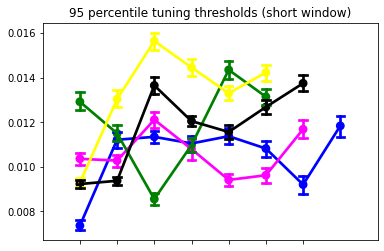

In [92]:
# Plot tuning thresholds across sessions for each mouse
import seaborn as sns

colors = ['blue', 'magenta', 'green', 'yellow', 'black']
for m, mouse in enumerate(mice):  
    df = thresholds95.loc[:,thresholds95.columns.str.contains(str(mouse))]
    df.sort_index(axis=1, inplace=True)
    name = mouse+'_CFA'
    cfa = df[name]
    df.drop(name, axis=1, inplace=True)
    df[name]=cfa
    g = sns.pointplot(data=df, ci=68, capsize=.2, color=colors[m])
    g.set(xticklabels=[])
    g.set(xlim=(-1, 8))
    plt.title('95 percentile tuning thresholds (short window)')
    
plt.savefig(os.path.join(output_path, 'tuning thresholds 95.png'))
plt.show()